In [ ]:
!pip install sentence_transformers

In [2]:
import warnings
import os
import shutil
import pickle
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1 - Load the data

In [4]:
full_df = pd.read_csv("/content/drive/MyDrive/metadata.csv")
dfs = []
for year in range(2021, 2022):
    df = pd.read_csv(f"/content/drive/MyDrive/310Project/deduplicated_dataset_{year}.csv", index_col=0)
    df.drop(columns=["minhash"], inplace=True)
    dfs.append(df)
df = pd.concat(dfs)
# Left join on the "cord_uid" column
df = pd.merge(df, full_df[['cord_uid', 'abstract']], on="cord_uid", how="left")
df.dropna(subset=['abstract'], inplace=True) #drop articles with null abstracts
df.to_pickle("prepared_data.pkl")

In [5]:
df = pd.read_pickle("prepared_data.pkl")

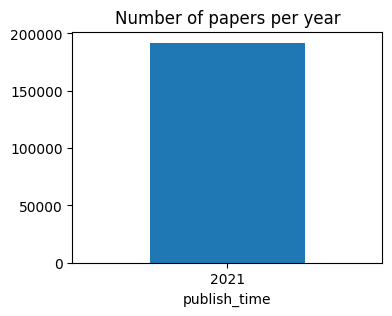

In [6]:
# Plot the number of papers per year
df.groupby("publish_time").count()["cord_uid"].plot(kind="bar",
    title="Number of papers per year", figsize=(4, 3))
plt.xticks(rotation=0)
plt.show()

# Step 1 - Get sentence embeddings

In [7]:
DEVICE = "cuda"
SENTENCE_ENCODER = SentenceTransformer('all-mpnet-base-v2', device=DEVICE)
embeddings = SENTENCE_ENCODER.encode(df.abstract.tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5997 [00:00<?, ?it/s]

In [ ]:
# embeddings = np.load("data/embeddings.npy")

In [8]:
# Concat embeddings to dataframe
df['Embeddings'] = list(embeddings)

# Step 2 - Topic Modeling for 2021

In [9]:
year = 2021

df_year = df[df.publish_time == year]
print(f"Processing year {year} with {len(df_year)} samples...")

Processing year 2021 with 191882 samples...


In [10]:
# Concat embeddings to dataframe
embedding_df = np.stack(df_year.Embeddings.tolist())
print(embedding_df.shape)

(191882, 768)


In [11]:
# Perform PCA
pca = PCA(n_components=0.90)
embedding_pca = pca.fit_transform(embedding_df)
print(f"Reduced {embedding_df.shape[1]} to {embedding_pca.shape[1]} dimensions.")

Reduced 768 to 217 dimensions.


# MiniBatchKMeans

In [12]:
#use minibatchkmeans to find the optimal number of clusters
# initialize the cluster range and inertia dictionary
kmeans_data = {}
for k in tqdm(range(10, 500, 5)):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=1000, max_iter=100)
    kmeans.fit(embedding_pca)
    kmeans_data[k] = dict(
        labels=kmeans.labels_,
        inertia=kmeans.inertia_,
    )

100%|██████████| 98/98 [09:31<00:00,  5.83s/it]


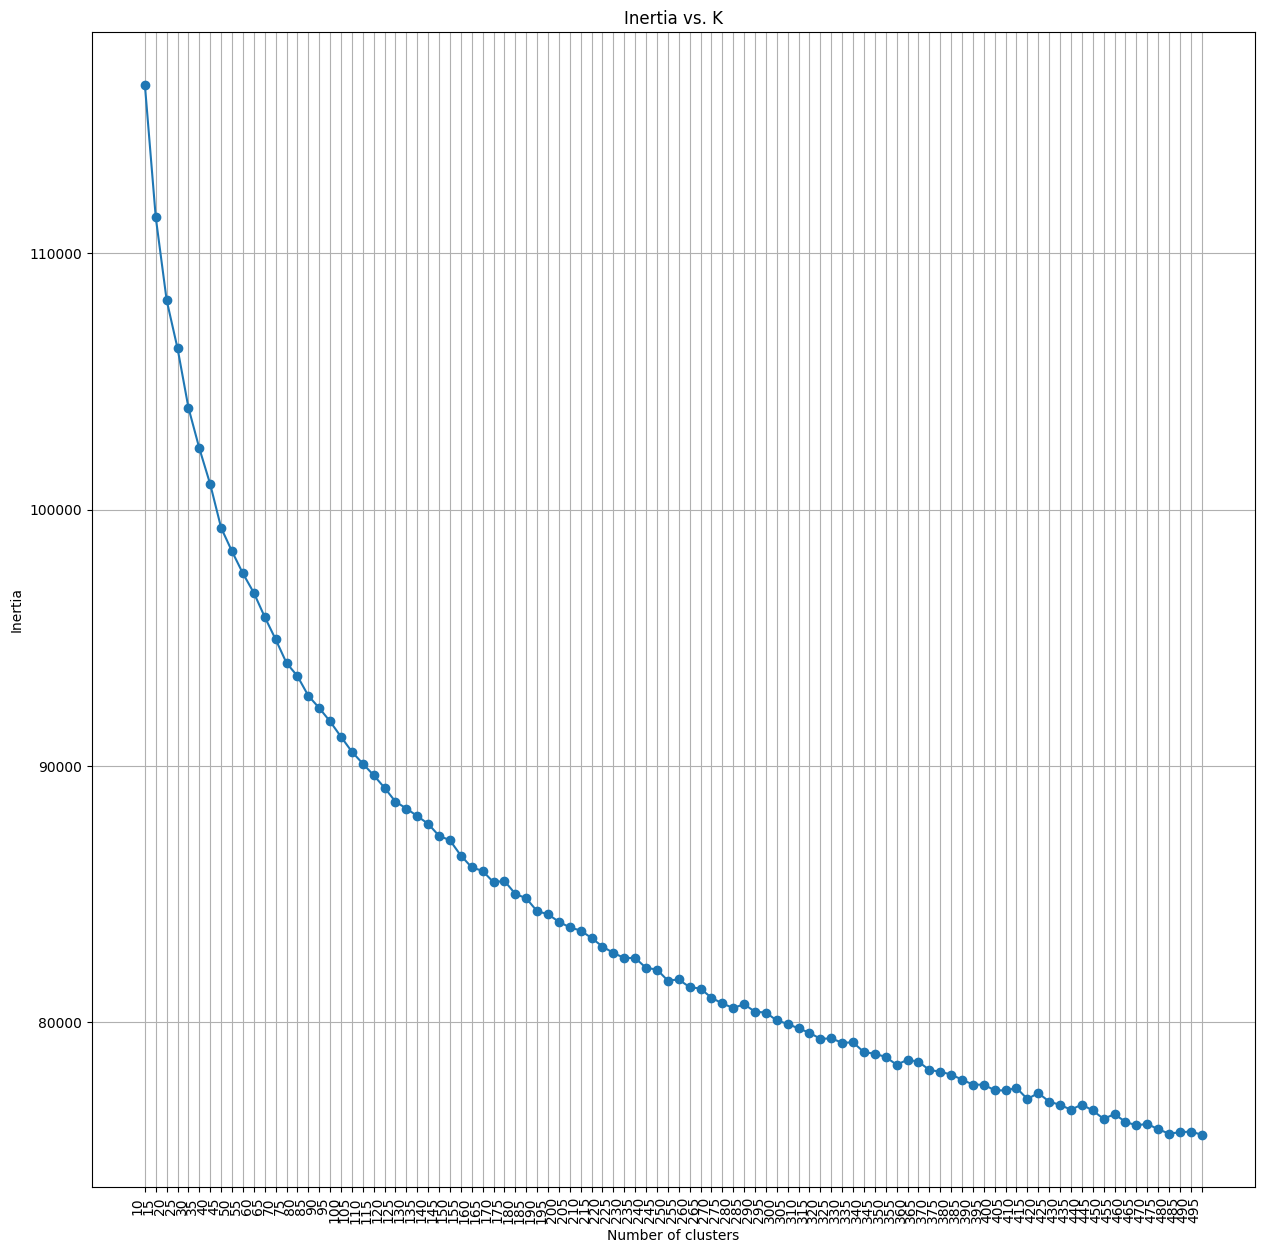

In [13]:
# plot the inertia vs. K
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(list(kmeans_data.keys()), [km['inertia'] for km in kmeans_data.values()], marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Inertia vs. K')
ax.set_xticks(list(kmeans_data.keys()))
ax.grid(True)
plt.xticks(rotation=90, ha='right')
plt.show()

In [14]:
# choose K = 300
k = 300

In [15]:
# save the labels
topic_idx = kmeans_data[k]['labels']
df_year['topics300_idx'] = topic_idx
df_year.to_pickle('/content/drive/MyDrive/310Project/2021_df_year.pkl')

In [ ]:
# tsne
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_pca)

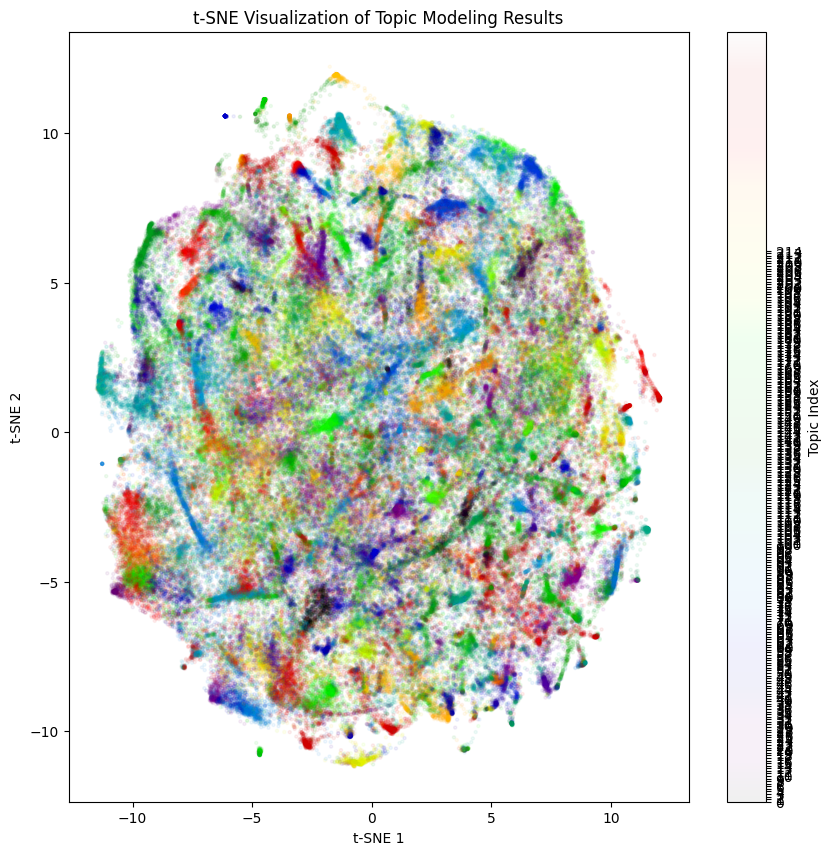

In [ ]:
# Plot the T-SNE results
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(tsne_results[:,0], tsne_results[:,1], c=df_year.topics300_idx,
                     cmap=plt.cm.nipy_spectral, alpha=0.06, s=5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization of Topic Modeling Results")
# Add a colorbar for reference
cbar = plt.colorbar(scatter, ticks=range(215))
cbar.set_label('Topic Index')
plt.show()


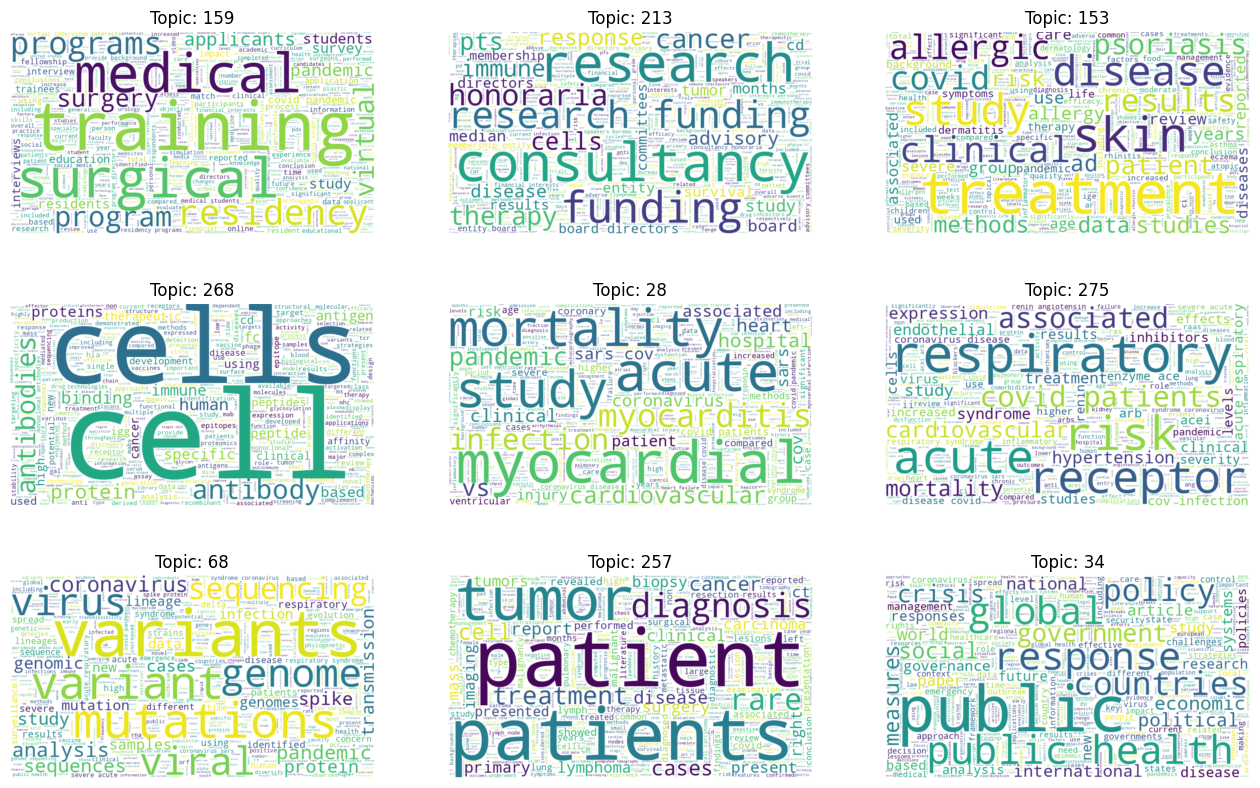

In [ ]:
# Generate word cloud for 9 random selected topics
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()
pattern = re.compile("[^a-zA-Z]")

keywords = []

for ax_index, i in enumerate(np.random.choice(list(range(300)), 9, replace=False)):
    df_topic = df_year[df_year.topics300_idx == i]

    corpus = df_topic.abstract.values
    # Remove non-alphabetical characters
    corpus = [re.sub(pattern, " ", text) for text in corpus]

    # Use CountVectorizer to extract frequencies since it is more flexible
    # Remove words that appear in more than 50% of the documents
    # Also include bigrams
    vectorizer = CountVectorizer(max_df=0.5, stop_words="english",
                                 lowercase=True, ngram_range=(1, 2), max_features=1000)
    vectorizer.fit(corpus)

    # Get the word frequencies dict(string:float)
    # tokens = vectorizer.get_feature_names()
    tokens = vectorizer.get_feature_names_out()
    freqs = vectorizer.transform(corpus).sum(axis=0).A1
    freqs = freqs / freqs.max()
    tokens_to_freqs = dict(zip(tokens, freqs))
    # Sort the dict by values
    tokens_to_freqs = dict(sorted(tokens_to_freqs.items(), key=lambda x: x[1], reverse=True))
    # Get the top 10 keywords
    keywords.append(list(tokens_to_freqs.keys())[:10])

    # Word cloud
    wordcloud = WordCloud(width=900, height=500,
                          background_color="white", max_words=1628,
                          relative_scaling=1, normalize_plurals=False).generate_from_frequencies(tokens_to_freqs)
    wordcloud.to_file("/content/drive/MyDrive/310Project/topic_" + str(i) + ".png")
    ax = axes[ax_index]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title("Topic: " + str(i))



plt.show()

In [ ]:
# Save the keywords to file
with open("/content/drive/MyDrive/310Project/keywords.json", 'w') as f:
    json.dump(keywords, f)

# Text Summarization

#### restart the kernal is strongly recommended before run the following code

In [4]:
# Load the dataframe
BART_SUMMARIZER = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# Load the dataframe
df_2021 = pd.read_pickle("/content/drive/MyDrive/310Project/2021_df_year.pkl")
df_2021.columns

Index(['cord_uid', 'title', 'publish_time', 'language', 'abstract',
       'Embeddings', 'topics300_idx'],
      dtype='object')

In [6]:
# Get the representative articles for each topic

topic_repr_articles = {}

for topic_idx in tqdm(df_2021.topics300_idx.unique()):
    # Get the embeddings for the topic
    df_topic = df_2021[df_2021.topics300_idx == topic_idx]
    # if length of topic < 20, skip
    if len(df_topic) < 20:
        continue
    topic_embeddings = np.stack(df_topic.Embeddings.values)

    # Perform PCA
    pca = PCA(n_components=0.9)
    emb_pca = pca.fit_transform(topic_embeddings)

    # Perform KMeans
    n_repr_articles = 5
    km = KMeans(n_clusters=n_repr_articles, random_state=0)
    km.fit(emb_pca)
    labels = km.labels_
    centroids = km.cluster_centers_

    # Get the representative articles based on the centroids
    repr_articles = []
    for label, centroid in zip(range(n_repr_articles), centroids):
        distances = np.linalg.norm(emb_pca - centroid, axis=1)
        repr_articles.append(df_topic.iloc[np.argmin(distances)].abstract)
    # Save the representative articles
    topic_repr_articles[topic_idx] = repr_articles

100%|██████████| 300/300 [02:02<00:00,  2.45it/s]


In [7]:
# Save topic_repr_articles
topic_repr_articles = {int(key): value for key, value in topic_repr_articles.items()}
with open("/content/drive/MyDrive/310Project/topic_repr_articles.json", 'w') as f:
    json.dump(topic_repr_articles, f)

In [51]:
topic_idx = 88
#print (topic_repr_articles[topic_idx]) in a more readable way with rank

# print (topic_repr_articles[topic_idx])
# print ("")

# for i in range(0, len(topic_repr_articles[topic_idx])+1):
#     print (topic_repr_articles[topic_idx][i])
#     print ("")

for i in range(0, len(topic_repr_articles[topic_idx])):
    print(topic_repr_articles[topic_idx][i])
    print("")

This paper voices the opinions of international students’ from China and India, and highlights the intentional process of integrating their perceptions of internationalization into a strategic service delivery plan. Data on those perceptions were analysed using a probabilistic model. We clustered 766 international students’ opinions into categories that enabled us to determine the main ideas that constituted their perceptions. The findings enabled us to draw comparisons between two major sending countries and to formulate a series of recommendations for stakeholders in higher education institutions that receive Chinese and Indian students, as well as for policymakers. Primary differences relate to factors such as learning and internship opportunities for Chinese students and service provision for Indian ones. In conclusion, this study offers the next step in the analysis of Chinese and Indian international students’ needs providing with an innovative way of determining students concern

In [18]:
# Load topic_repr_articles and convert keys to int
with open("/content/drive/MyDrive/310Project/topic_repr_articles.json", 'r') as f:
    topic_repr_articles = json.load(f)
topic_repr_articles = { int(k): v for k, v in topic_repr_articles.items() }

In [19]:
import os
import json

file_path = "/content/drive/MyDrive/310Project/summaries.json"

# Check if the file exists
if not os.path.isfile(file_path):
    print(f"File not found: {file_path}")
    # Handle the case where the file doesn't exist by creating an empty dict
    topic_summaries = {}
else:
    # If the file exists, proceed to load it
    with open(file_path, 'r') as f:
        topic_summaries = json.load(f)
    topic_summaries = {int(k): v for k, v in topic_summaries.items()}

In [ ]:
# # Load the summaries
# with open("/content/drive/MyDrive/310Project/summaries.json", 'r') as f:
#     topic_summaries = json.load(f)
# topic_summaries = { int(k): v for k, v in topic_summaries.items() }

In [20]:
# Summarize the articles
for topic_idx in tqdm(df_2021.topics300_idx.unique()):
    topic_idx = int(topic_idx)

    # If topic already done, skip
    if topic_idx in topic_summaries or topic_idx not in topic_repr_articles:
        continue

    # Get the representative articles
    repr_articles = topic_repr_articles[topic_idx]
    # Summarize the articles
    summaries = []
    for article in repr_articles:

        # If number of tokens > 1023, discard the texts after that
        # Since the maximum allowed length to BART summarizer is 1024
        tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
        ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        while len(ids) > 1023:
            # If too long, cut half of an article
            article = article[:(len(article) // 2)]
            tokens = BART_SUMMARIZER.tokenizer.tokenize(article)
            ids = BART_SUMMARIZER.tokenizer.convert_tokens_to_ids(tokens)

        # If length is already too short, we use itself as summary
        if len(tokens) < 50:
            sumamry = article
        else:
            summary = BART_SUMMARIZER(article, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

        summaries.append(summary)
    # Save the summaries
    topic_summaries[topic_idx] = summaries

    with open("/content/drive/MyDrive/310Project/summaries.json", 'w') as f:
        json.dump(topic_summaries, f)

100%|██████████| 300/300 [00:00<00:00, 183397.64it/s]


In [52]:
# Print the summaries
topic_idx = 88
# for i in range(5):
#     print (topic_summaries[topic_idx][i])
#     print ("")

for i in range(0, len(topic_summaries[topic_idx])):
    print (topic_summaries[topic_idx][i])
    print ("")

This paper voices the opinions of international students’ from China and India. Data on those perceptions were analysed using a probabilistic model. The findings enabled us to draw comparisons between two major sending countries.

There are multiple factors that can potentially impact the career progression of academics to professoriate level (referred to as levels D and E in Australia) This research provides a detailed understanding of critical factors (by gender) that negatively influence career progress

The study was anonymous and encompassed a sample of 140 students. The surveys were conducted in the third quarter of 2020, after the SARS-CoV-2 pandemic outbreak. The respondents would like their future, post-p

The purpose of this research was to explore the relationship between university students’ perceptions of the overall quality of instruction (PQI) and their academic well-being. This relationship was examined in the context of a moderated moderation with

The purpose of this 

# Evaluation

In [55]:
!pip install bert_score --quiet

In [43]:
from bert_score import BERTScorer

In [45]:
ref_summary_0 = "The introduction of Wolbachia-infected Aedes aegypti mosquitoes in Niterói, Brazil, significantly reduced the incidence of dengue, chikungunya, and Zika viruses. Despite varying levels of Wolbachia prevalence in mosquito populations, a notable public health benefit was observed, with up to a 69% reduction in dengue cases. Concurrently, research on dengue virus (DENV) in Brazil reveals varying clinical outcomes associated with different DENV-2 strains, emphasizing the challenges in managing the disease, which lacks a reliable animal model for research. Another study highlights the complications of COVID-19 and dengue co-infections, stressing the need for precise diagnostics due to overlapping symptoms. In Odisha, a significant prevalence of dengue and chikungunya was documented, underlining the need for enhanced surveillance and management strategies. Lastly, a systematic review suggests that previous dengue infections might influence the severity of Zika-related microcephaly, pointing to immune responses as a potential factor in the geographical variability of Zika's impact."

eval_summary_0 = " ".join(topic_summaries[0])

print(type(eval_summary_0))

<class 'str'>


In [46]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Calculate BERTScore for the summary against the excerpt
# P1, R1, F1_1 represent Precision, Recall, and F1 Score respectively
P1, R1, F1_1 = scorer.score([eval_summary_0], [ref_summary_0])


print("Summary 0 F1 Score:", F1_1.tolist()[0])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary 0 F1 Score: 0.854776918888092


In [48]:
ref_summary_77 = "The COVID-19 pandemic has significantly impacted the landscape of remote work, intensifying its adoption across various sectors. Historical data from the U.S. highlight a gradual increase in work-from-home (WFH) arrangements even before the pandemic, with a notable rise in professional workers adopting remote work as a primary mode of employment. The pandemic escalated this trend, forcing a widespread transition to WFH, which brought about diverse challenges and adaptations in work-life balance, productivity, and employee well-being.Several studies have explored the effects of this shift. One study involving 1,000 professionals used descriptive statistics to understand the impact of WFH during the pandemic, revealing concerns about COVID-19 exposure and significant distress due to increased work commitments and family distractions. Another study employed a unique methodology involving photographs and an online survey to assess the ergonomic conditions of home offices, although it faced challenges in data collection. Additionally, management perspectives from two organizations highlighted the challenges in maintaining communication and productivity during the sudden shift to remote work.The overall findings suggest that while remote work can enhance job satisfaction by reducing commutes and allowing flexibility, it also raises issues of professional isolation and stress due to blurred boundaries between work and home life. The pandemic has underscored the need for effective management strategies and tools to support remote employees, emphasizing the importance of flexible work arrangements as a permanent feature of the modern workplace."

eval_summary_77 = " ".join(topic_summaries[77])

print(type(eval_summary_77))

<class 'str'>


In [50]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Calculate BERTScore for the summary against the excerpt
# P1, R1, F1_1 represent Precision, Recall, and F1 Score respectively
P1, R1, F1_1 = scorer.score([eval_summary_77], [ref_summary_77])


print("Summary 77 F1 Score:", F1_1.tolist()[0])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary 77 F1 Score: 0.8542911410331726


In [53]:
ref_summary_88 = "This collection of studies explores the impacts of the COVID-19 pandemic on various aspects of academia and employment, focusing on the integration and progression within educational and professional settings. One study highlights the analysis of perceptions of internationalization among Chinese and Indian international students, leading to strategic recommendations for higher education institutions in handling these demographics effectively. Another research emphasizes the barriers to career progression among academics, particularly female academics in STEMM and business disciplines, identifying organizational factors like heavy workloads and insufficient resources as significant impediments.Further research conducted in Poland gauges the post-pandemic job expectations of Generation Y, underscoring a preference for job satisfaction over traditional career progression, with many leaning towards self-employment for better work-life balance. Another study examines the academic well-being of university students in the U.S. and South Africa, revealing complex interactions between perceived quality of instruction, household income, and cultural values, impacting students’ academic experiences during the pandemic.Lastly, a study on higher education employees focuses on the perceptions of organizational discipline amid the shift to online teaching, proposing a new scale for assessing this within the academic sector. This body of research collectively provides insights into the evolving dynamics of work and education environments in response to global disruptions, offering actionable strategies for managing and improving these domains."

eval_summary_88 = " ".join(topic_summaries[88])

print(type(eval_summary_88))

<class 'str'>


In [54]:
# Instantiate the BERTScorer object for English language
scorer = BERTScorer(lang="en")

# Calculate BERTScore for the summary against the excerpt
# P1, R1, F1_1 represent Precision, Recall, and F1 Score respectively
P1, R1, F1_1 = scorer.score([eval_summary_88], [ref_summary_88])


print("Summary 88 F1 Score:", F1_1.tolist()[0])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary 88 F1 Score: 0.8466158509254456
